# Overview

Specify a data folder. Run all the cleaning functions. 
Using the cleaning routine, you need to determine the start and end of activity manually.
Once clean, we can process the EDA data and extract phasic and SMNA data. 

In [400]:
folder = "irb/111"
SESSION_ID = "CHI2019"

# Cleaning Functions
Run all these cells.

In [404]:
import json, os, csv, platform, datetime, time
from glob import glob
import numpy as np
from pprint import pprint
from matplotlib import pyplot as pl

DATA_ROOT = "irb"

E4_MANIFEST = {
    'phasic': {
        'name': "Phasic GSR",
        'description': "Event-specific EDA"
    },
    'smna':{
        'name': "SMNA",
        'description': "sparse SMNA driver of phasic component"
    },
    'textchunk': {
        'name': "Text Chunk",
        'description': "Values correspond to typing behaviors.  # of consecutive characters typed."
    },
    'temp': {
        'name': "Temperature",
        'description': "Data from temperature sensor expressed degrees on the Celsius (°C) scale.",
        'unit': "celsius"
    },
    'tags':{
        'name': "Tags",
        'description': "Event mark times. Each row corresponds to a physical button press on the device; the same time as the status LED is first illuminated. The time is expressed as a unix timestamp in UTC and it is synchronized with initial time of the session indicated in the related data files from the corresponding session."
    },
    'acc':{
        'description': "Data from 3-axis accelerometer sensor. The accelerometer is configured to measure acceleration in the range [-2g, 2g]. Therefore the unit in this file is 1/64g. Data from x, y, and z axis are respectively in first, second, and third column.",
        'name': "3-Axis Accelerometer",
        'unit': "1/64g"
    }, 
    'eda':{
        'description': "Data from the electrodermal activity sensor expressed as microsiemens (μS).", 
        'name':"Electrodermal Activity",
        'unit': "μS"
    }, 
    'bvp':{
        'name': "Blood Volume Pulse (BVP) from PPG",
        'description': "Data from photoplethysmograph.",
    }, 
    'ibi':{
        'name': "IBI", 
        'description': "Time between individuals heart beats extracted from the BVP signal. No sample rate is needed for this file. The first column is the time (respect to the initial time) of the detected inter-beat interval expressed in seconds (s). The second column is the duration in seconds (s) of the detected inter-beat interval (i.e., the distance in seconds from the previous beat)."
    },
    'hr':{
        'name': "Heart rate", 
        'description': "Average heart rate extracted from the BVP signal.The first row is the initial time of the session expressed as unix timestamp in UTC. The second row is the sample rate expressed in Hz."
    }
}

def save_jsonfile(name, data):
    with open(name, 'w') as outfile:
        json.dump(data, outfile)
    print("File saved!", name)
def gen_save_file(folder, feature):
    user = os.path.basename(folder)
    return os.path.join(folder, feature + "_" + user + ".json")
def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
        print("File not found", prefix, 'in', folder)
        return None
    else: 
        with open(files[0], 'r+') as f: 
            contents = json.load(f)
            return contents, files[0]
def adjust_data(data, t, Fs):
    metadata,f = get_file(folder, "sessionmetadata")
    # ADJUST Y AND T RANGE    
    start = metadata["session_start"] - t
    end = metadata["session_end"] - t    
    t0 = start * Fs 
    t0 = start * Fs  if start > 0 else 0
    tf = end * Fs - 1 if end < len(data) else len(data)
    data = data[t0:tf]
    return data

In [403]:
# MAKING A SESSION METADATA JSON
def session_metadata(folder):
    data = {}
    data['session_start'] = session_start
    data['session_end'] = session_end
    data['elapsed_time'] = session_end - session_start
    
    log = ["ACC_START", time.ctime(eda_start), "SESSION_START", time.ctime(session_start), "SESSION_END", time.ctime(session_end), "ELAPSED", str(end-start)]
    data['description'] =  "\n".join(log)
    savefile = gen_save_file(folder, "sessionmetadata")
    save_jsonfile(savefile, data)

In [19]:
def find_session(folder, start):
    contents, filename = get_file(folder, "acc")
    fig, ax = pl.subplots()
    
    eda_start = None
    eda_Fs = None
    
    data = contents["data"]

    eda_start = contents["timestamp"]
    eda_Fs = contents["sampling_rate"]

    # PLOTTING ACCELERATION VALUES       
    data = np.array(data, dtype='f')
    ax.plot(data[:, 0], 'r')
    ax.plot(data[:, 1], 'g')
    ax.plot(data[:, 2], 'b')

    # ADDING TAG EVENTS
    contents, f = get_file(folder, "tags")
    data = contents["data"]
    for tag in data:
        elapsed_time = tag - eda_start
        x = elapsed_time * eda_Fs                
        ax.axvline(x=x)

    # ADD LOG EVENTS
    contents, f = get_file(folder, "log") 
    data = contents["data"]

    timestamps = [d['time'] for d in data]
    for tag in timestamps:
        elapsed_time = tag - eda_start
        x = elapsed_time * eda_Fs    
        ax.axvline(x=x, color='y')


    def onclick(event):
        global edaFs, eda_start
        ix, iy = event.xdata, event.ydata
        if start:
            global session_start
            session_start = eda_start + (ix/eda_Fs)
        else:
            global session_end
            session_end = eda_start + (ix/eda_Fs)
        return False
    def handle_close(evt):
        print('Closed Figure!')
        print("START", time.ctime(eda_start))

    cid = fig.canvas.mpl_connect('close_event', handle_close)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    return eda_start, eda_Fs

# Cleaning Routine

1. Run session_start and click on the start of the activity. 
2. Run session_end and click on the start of the activity. 
3. Verify start/end
4. Generate sessionmetadata file.
5. Run EDA analysis.

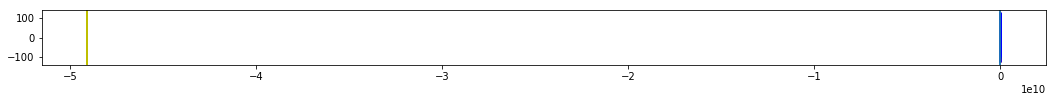

In [405]:
#FIND SESSION START
session_start = None
eda_start, edaFs = find_session(folder, True)

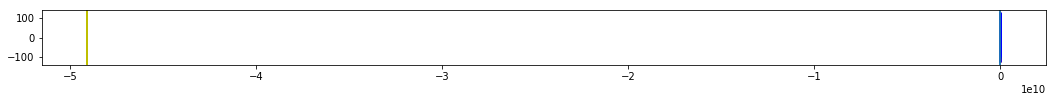

In [406]:
# FIND SESSION END
session_end = None
eda_start, edaFs = find_session(folder, False)

In [407]:
# REVIEW INFORMATION
end = datetime.datetime.fromtimestamp(session_end)
start = datetime.datetime.fromtimestamp(session_start)

print(time.ctime(eda_start))
print(time.ctime(session_start))
print(time.ctime(session_end))
print("ELAPSED", str(end-start))

TypeError: an integer is required (got type NoneType)

In [ ]:
# HAPPY?
session_metadata(folder)